# Snow cover analysis with SNOW CCI data
* Making local and spatial mean and trend analysis
* Using snow cover duration, a variable expected to be less affected by missing data?
* Using GMTED2010 surface elevation data to investigate the potential dependency of snow trends to elevation
* To make comparisons with surface temperature trends using E-OBS dataset? Other datasets?

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys
import calendar as cal

In [2]:
#seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/daily/' # local, first test for only one year
save_data = '/data/mmenegoz/use_case_cci_snow'

In [3]:
%%time
# First test over the Alps
first_year=1982
last_year=2018
period = slice(str(first_year)+'-01-01',str(last_year)+'-12-31')
# Alpine domain
lat1=43; lat2=48; lon1=5; lon2=17
latlim_ext,lonlim_ext=slice(lat1,lat2), slice(lon1,lon2)
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data+'/Alpine_snow.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data+'/Alpine_snow.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data+'/Alpine_snow.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc already exists
CPU times: user 13.7 ms, sys: 7.64 ms, total: 21.3 ms
Wall time: 373 ms


In [4]:
ds_alps

<xarray.Dataset>
Dimensions:          (lat: 100, lon: 240, time: 13422)
Coordinates:
  * lat              (lat) float64 43.02 43.08 43.12 43.17 ... 47.88 47.92 47.98
  * lon              (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * time             (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    coverage         (time, lat, lon) int64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    coverage_interp  (time, lat, lon) int64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [5]:
time_extract='2001-03-01'
ds_alps_check=ds_alps.sel(time=time_extract)

Topography

In [6]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev

Plot

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
cmap='Blues'
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

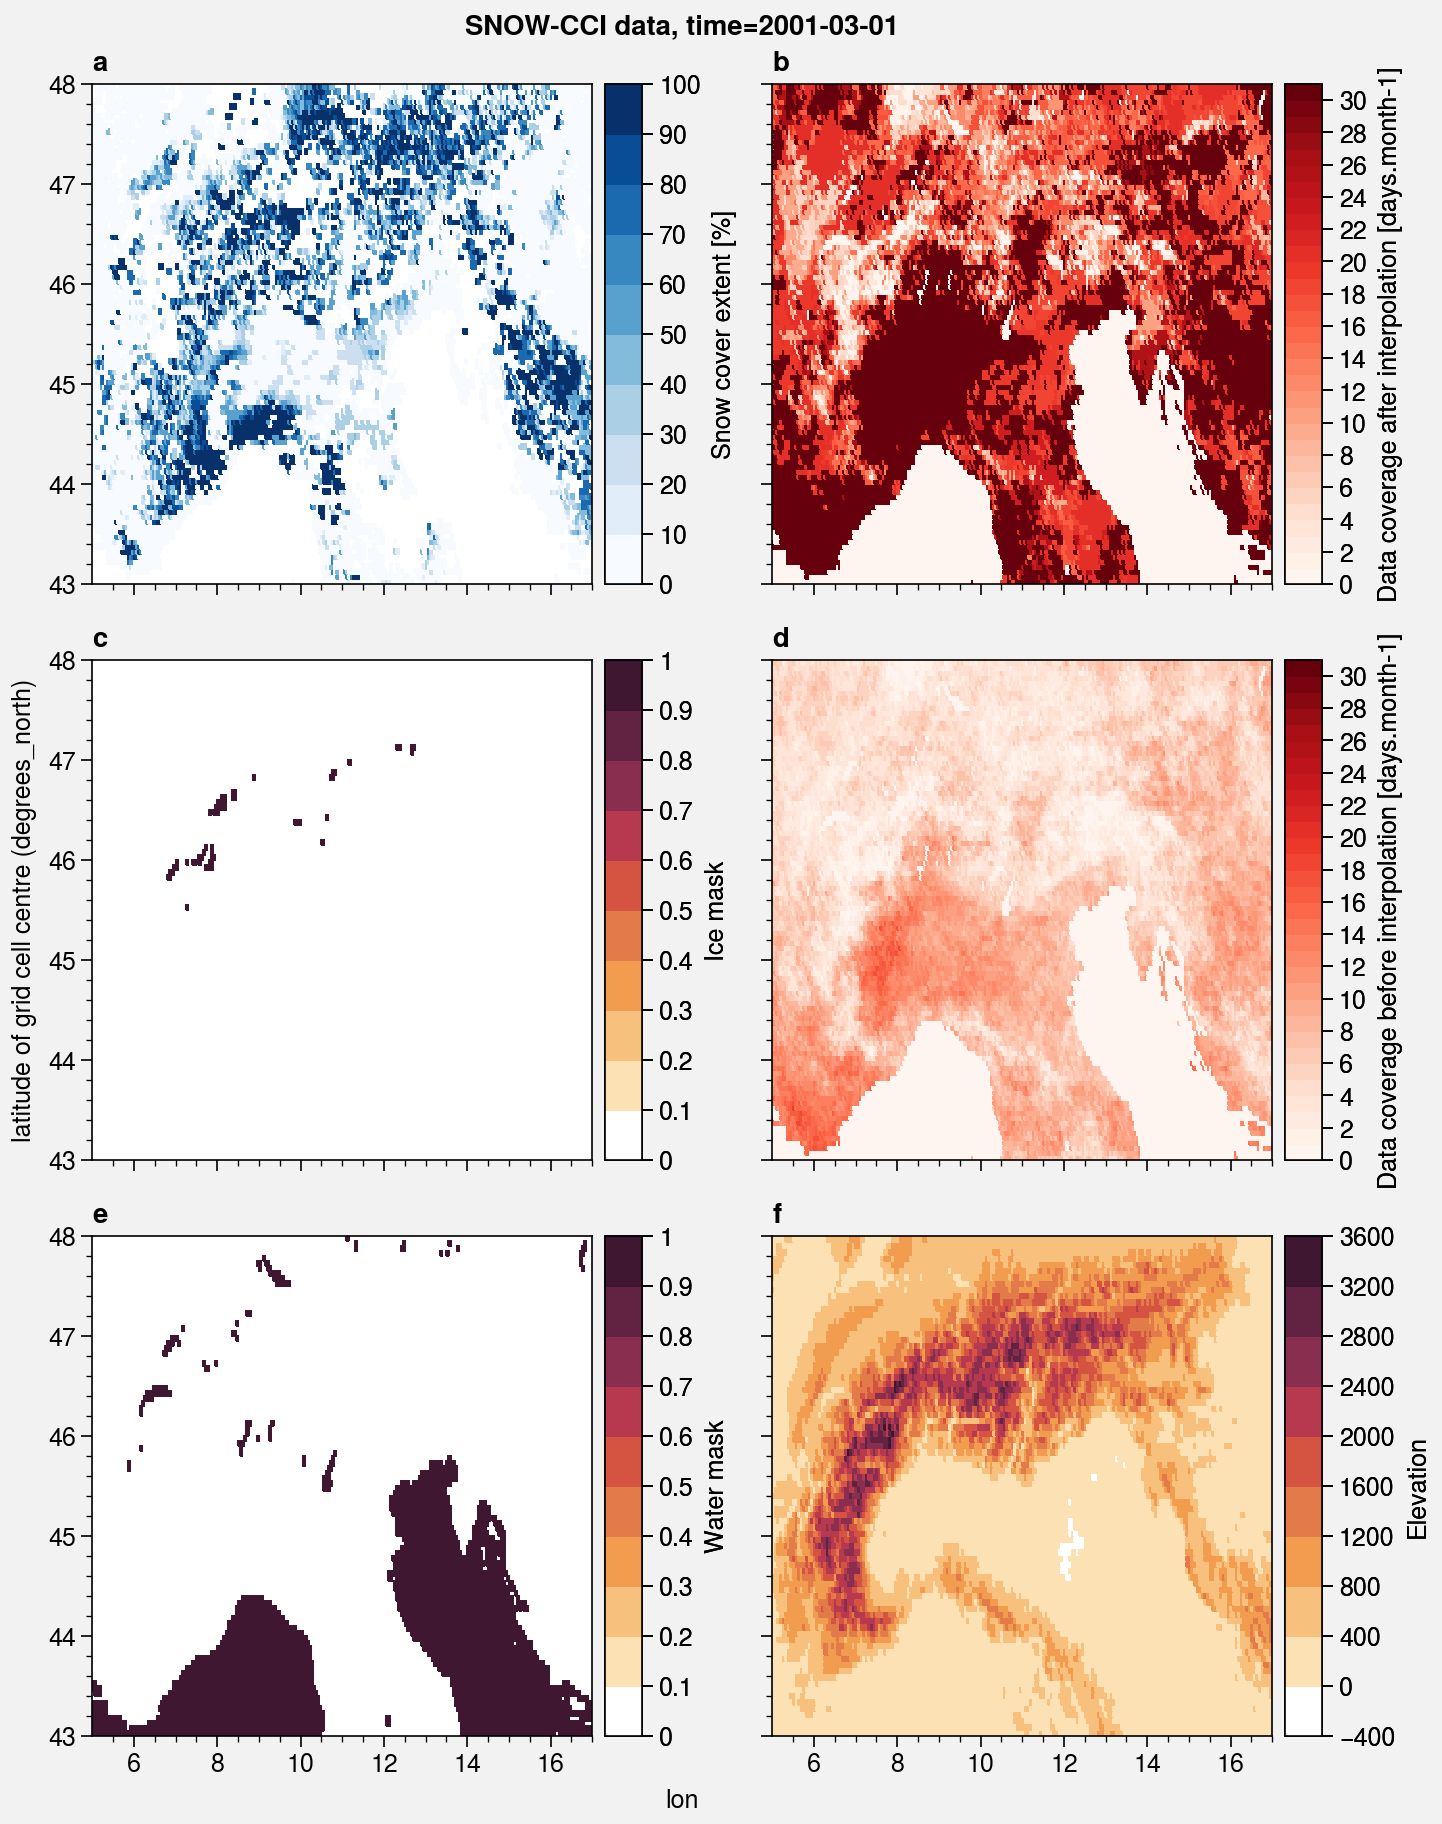

In [9]:
fig,axs = plot.subplots(nrows=3, ncols=2)
axs[0,0].pcolormesh(ds_alps_check.scfg_interp, levels=levels, colorbar='r', cmap=cmap, colorbar_kw={'label': 'Snow cover extent [%]'})
axs[0,1].pcolormesh(ds_alps_check.coverage_interp, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage after interpolation [days.month-1]'})
axs[1,0].pcolormesh(ds_alps_check.mask_ice, colorbar='r',colorbar_kw={'label': 'Ice mask'})
axs[1,1].pcolormesh(ds_alps_check.coverage, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage before interpolation [days.month-1]'})
axs[2,0].pcolormesh(ds_alps_check.mask_water, colorbar='r',colorbar_kw={'label': 'Water mask'})
axs[2,1].pcolormesh(elevation, colorbar='r',colorbar_kw={'label': 'Elevation'})
axs.format(
    suptitle='SNOW-CCI data, time='+time_extract,
    abc=True
)

In [10]:
dsi_topo = ds_topo.interp(lat=ds_alps.lat, lon=ds_alps.lon)

In [11]:
dsi_topo_check=dsi_topo.interp(lat=ds_topo.lat,lon=ds_topo.lon)

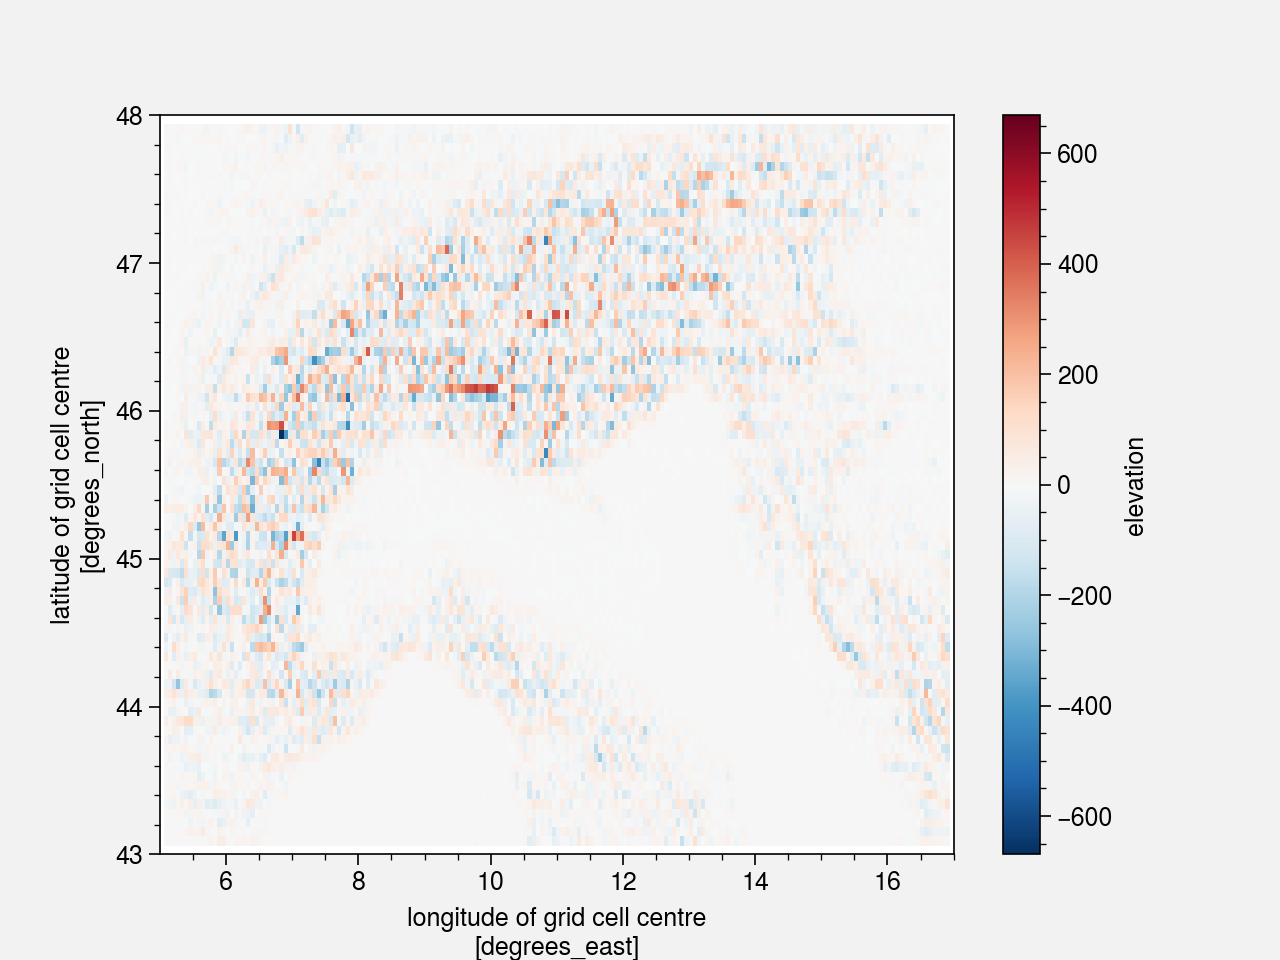

In [12]:
# Errors related to the interpolation applied two times
check=dsi_topo_check.elevation-ds_topo.elevation
check.plot()

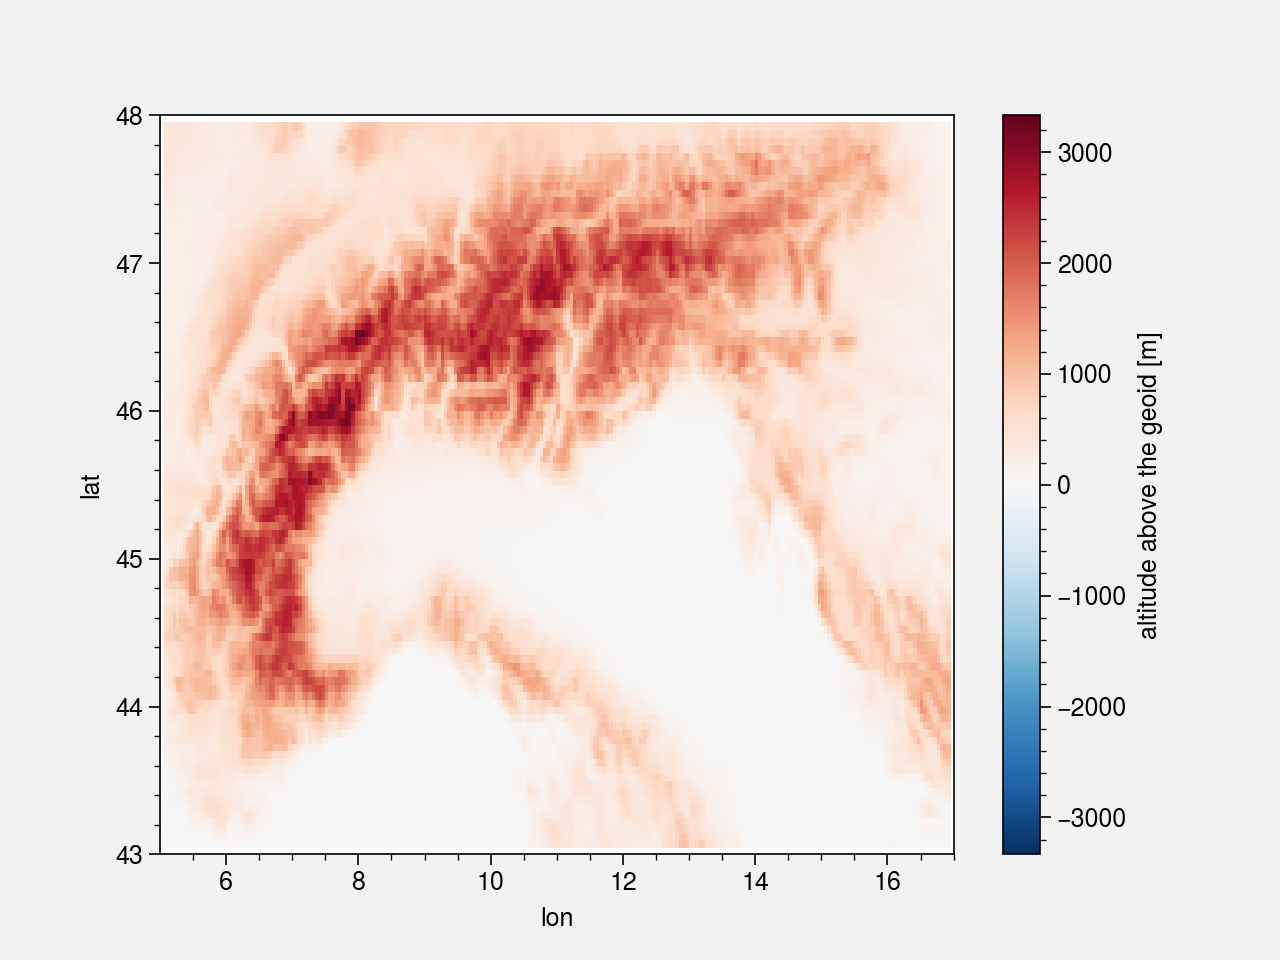

In [13]:
dsi_topo.elevation.plot()

In [14]:
# Testing 3D plots (Could be interesting for analysis on elevation bands?)

In [15]:
delta=0.05
latlim_short,lonlim_short=slice(44+delta,48-delta), slice(5+delta,17-delta)

In [16]:
x,y = np.meshgrid(dsi_topo.lon.sel(lon=lonlim_short),dsi_topo.lat.sel(lat=latlim_short))

In [17]:
dsi_topo_short=dsi_topo.elevation.sel(lon=lonlim_short,lat=latlim_short)
x.shape, y.shape, dsi_topo_short.shape

((78, 238), (78, 238), (78, 238))

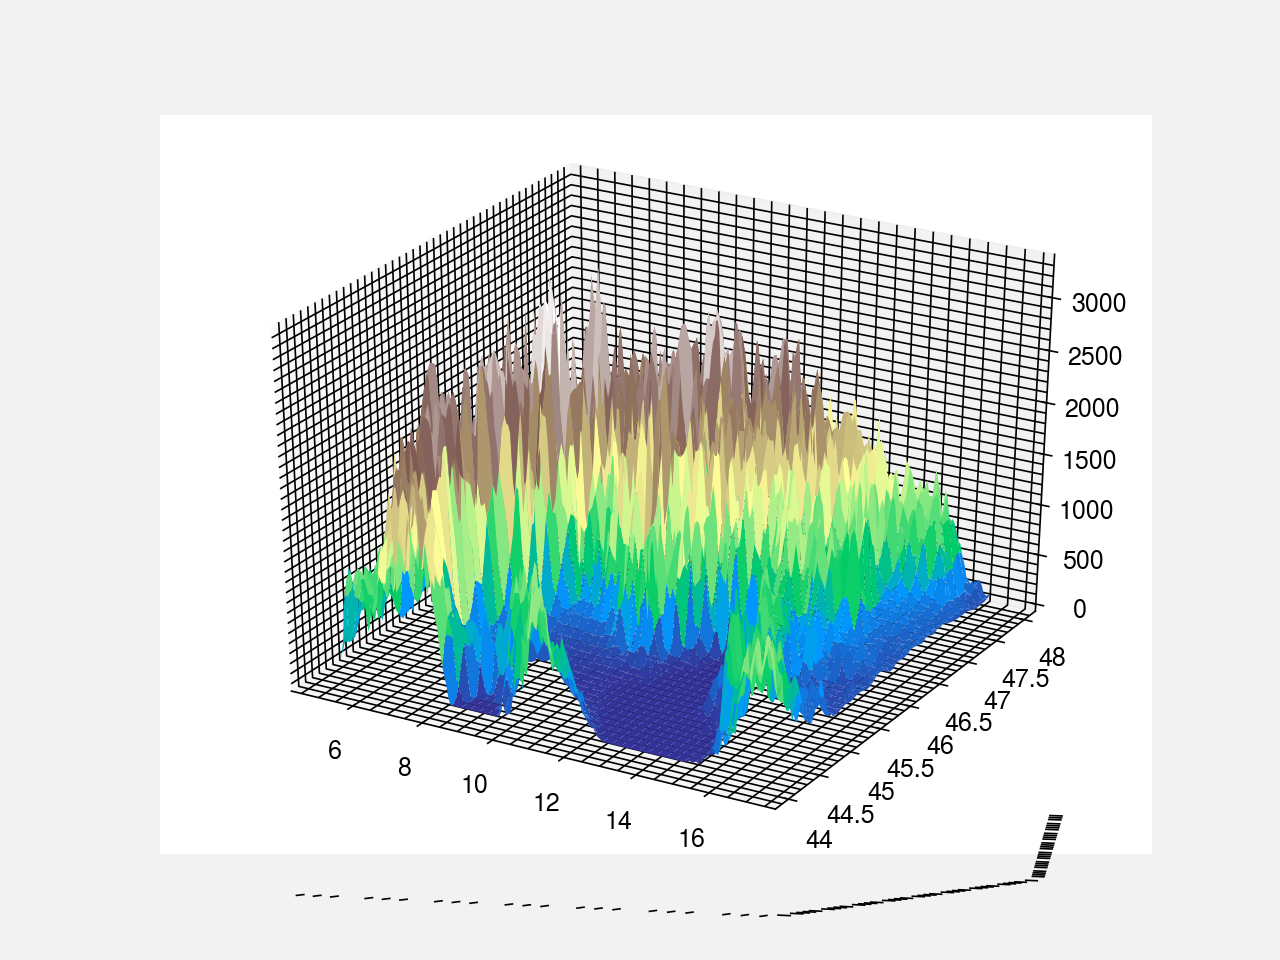

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,dsi_topo_short,cmap='terrain')

In [19]:
# Moving plot (Could be interesting for visualisation)
# https://jackmckew.dev/3d-terrain-in-python.html
#terrain_cmap = plt.cm.get_cmap('terrain')
#def matplotlib_to_plotly(cmap, pl_entries):
#    h = 1.0/(pl_entries-1)
#    pl_colorscale = []
#
#    for k in range(pl_entries):
#        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
#        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
#
#    return pl_colorscale
#
#terrain = matplotlib_to_plotly(terrain_cmap, 255)

In [20]:
#import plotly
#import plotly.graph_objects as go
#plotly.offline.init_notebook_mode(connected=True)
#
#fig = go.Figure(data=[go.Surface(colorscale=terrain,z=dsi_topo_short)])
#
#fig.update_layout(title='Random 3D Terrain')
#
# Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
#html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')

In [21]:
#from IPython.core.display import HTML
#HTML(html)

***Snow cover duration***

In [22]:
# Parameters to compute snow cover duration
scf_threshold=0.16
min_available_values=15
min_available_values2=20 # Second value for testing/comparison

In [23]:
# Defining the time for the monthly data
months_per_year=12
time_nbdays = pd.date_range(start=str(first_year)+'-01-01',end=str(last_year+1)+'-01-01',freq='M')
reference_time = pd.Timestamp(str(first_year)+'-01-01')

In [24]:
# Initialise 12 month per year nbdays array
path_nbdays = Path(save_data+'/Alpine_snow_nbdays.nc')
if path.is_file():
    print(f'The file {path} already exists')
else:
    ds_nbdays = xr.Dataset({
        'nbdays': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays',
            attrs=dict(
                description="snow cover duration, minimum available value="+str(min_available_values),
                units="days.month-1",
            ),
            ),
        'nbdays2': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays',
            attrs=dict(
                description="snow cover duration, minimum available value="+str(min_available_values2),
                units="days.month-1",
            ),
            ),
        'nbdays_filled': xr.DataArray(
            data=np.full((ds_alps.lat.shape[0],ds_alps.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lon=(["lon"], ds_alps.lon),
                lat=(["lat"], ds_alps.lat),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays_filled',
            attrs=dict(
                description="snow cover duration, monthly filled",
                units="days.month-1",
            ),
            )
        },
        attrs = {'documentation': 'Computing snow cover duration from CCI_SNOW snow cover fraction.\r'+
                 'Snow cover fraction threshold:'+str(scf_threshold*100)+'%.\r'+
                 'The data is monthly extrapolated in nbdays_filled when more than '+str(min_available_values)+' days of data is available'}
    )    

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc already exists


In [25]:
# nbdays calculation (the tricky part of the script)
# for each year and month, we select the gridcell with SCF > threshold=0.1,
# for which we consider that the gridcell is snow covered.
# Then we sum the snow covered days for each month where there is more than
# min_available_values (and min_available_values2 for comparison).
# Finally, the total number of snow covered days is extrapolated at the monthly timescale,
# extending the ratio (snow-covered days)/(number of days with available data) to the whole number of days in the month.
path_nbdays = Path(save_data+'/Alpine_snow_nbdays.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_nbdays = xr.open_mfdataset(save_data+'/Alpine_snow_nbdays.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    for iyear, year in enumerate(range(first_year, last_year+1, 1)):
        for imonth in range(1,months_per_year+1,1):
            numday_month=cal.monthrange(year, imonth)[1]
            print('year='+str(year)+', month='+str(imonth)+', number of days='+str(numday_month))
            if (year==1994 and (imonth==10 or imonth==11 or imonth==12)) or (year==1995 and imonth==1):
                print('no data for this period, we let the np.nan in the array')
            else:
                print('computing nbdays')
                ds_tmp=ds_alps.sel(time=str(year)+'-'+str(imonth))
                binary_tmp=xr.where(ds_tmp.scfg_interp > scf_threshold, 1., 0.)
                binary=xr.where(xr.ufuncs.isnan(ds_tmp.scfg_interp), np.nan, binary_tmp)
                xnbdays=binary.sum(dim='time',skipna=True,min_count=min_available_values)
                xnbdays2=binary.sum(dim='time',skipna=True,min_count=min_available_values2)
                cov=ds_alps.coverage_interp.sel(time=str(year)+'-'+str(imonth)+'-01')
                xnbdays_filled=(xnbdays/cov)*numday_month
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays_filled[:,:,0]=xnbdays_filled
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays[:,:,0]=xnbdays
                ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays2[:,:,0]=xnbdays2
    ds_nbdays.to_netcdf(save_data+'/Alpine_snow_nbdays.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow.nc already exists


In [26]:
# Check the result for one specific date
time_check='1993-11'
levels_nbdays=plot.arange(0,31,1)
levels_elev=plot.arange(0,1000,1000)
cmap='GnBu'

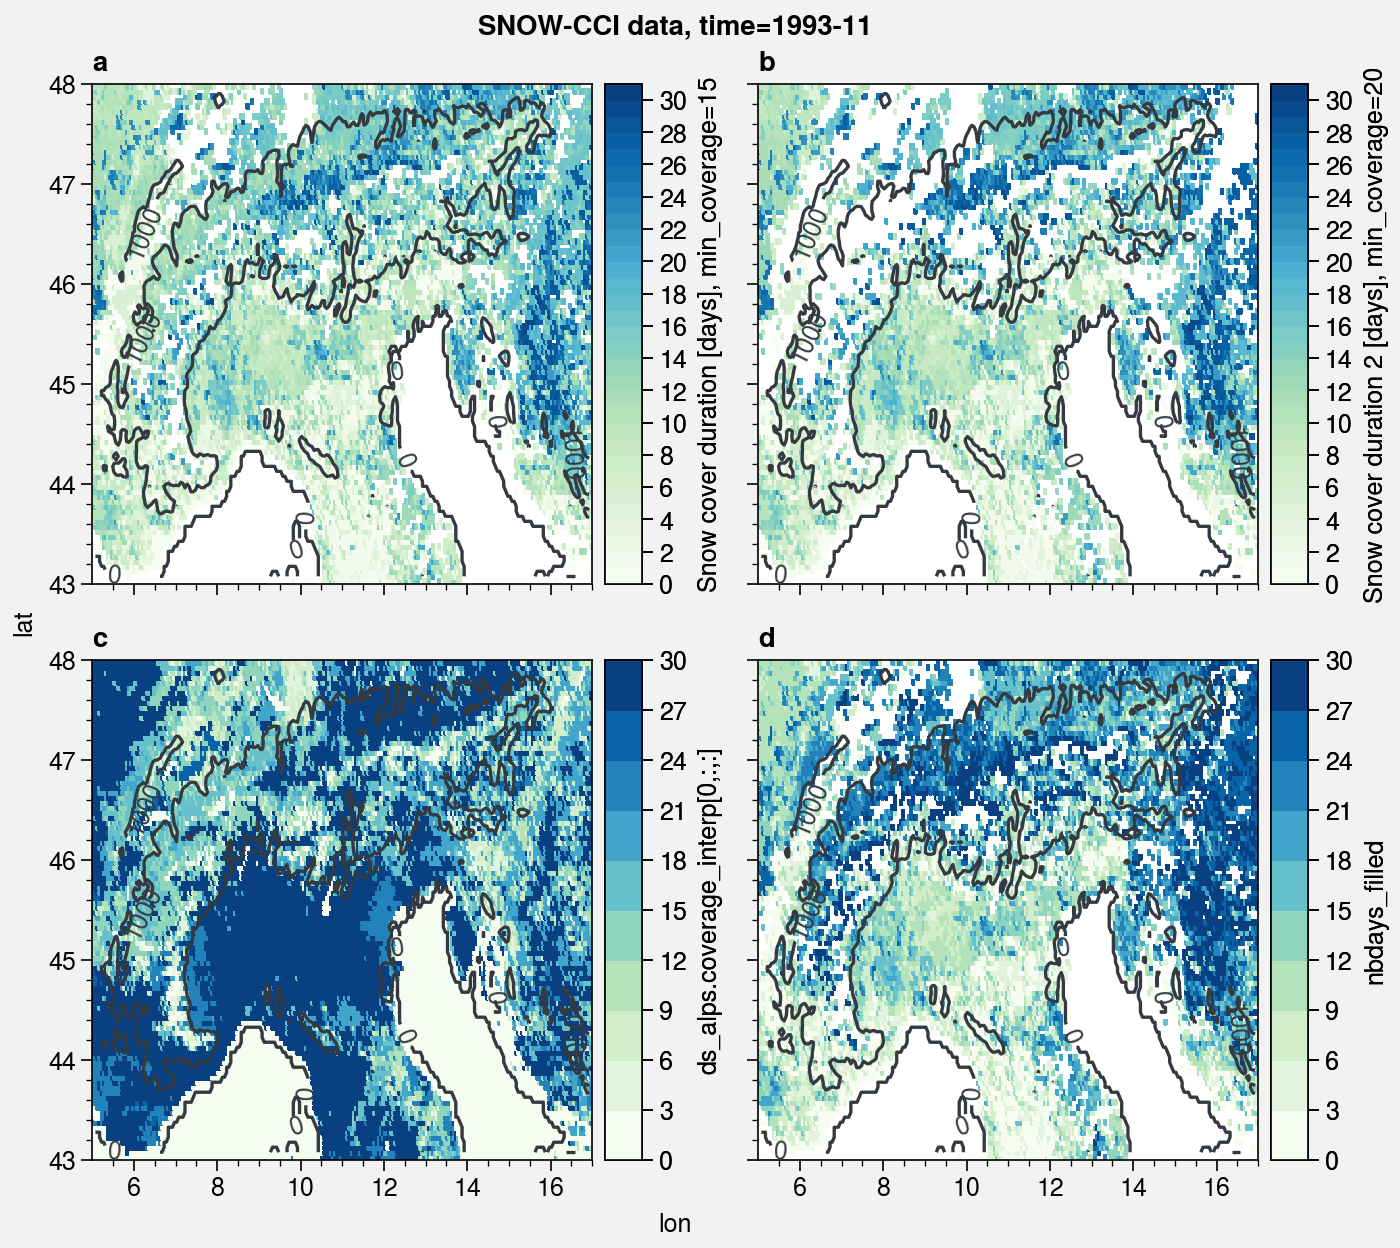

In [27]:
fig,axs = plot.subplots(nrows=2, ncols=2)
axs[0,0].pcolormesh(ds_nbdays.nbdays.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration [days], min_coverage='+str(min_available_values)})
axs[0,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[0,1].pcolormesh(ds_nbdays.nbdays2.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', colorbar_kw={'label': 'Snow cover duration 2 [days], min_coverage='+str(min_available_values2)})
axs[0,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,0].pcolormesh(ds_alps.coverage_interp.sel(time=time_check)[0,:,:], cmap=cmap, colorbar='r', colorbar_kw={'label': 'ds_alps.coverage_interp[0,:,:]'})
axs[1,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)
axs[1,1].pcolormesh(ds_nbdays.nbdays_filled.sel(time=time_check)[:,:,0], cmap=cmap, colorbar='r', colorbar_kw={'label': 'nbdays_filled'})
axs[1,1].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)

axs.format(
    suptitle='SNOW-CCI data, time='+time_check,
    abc=True
)

In [28]:
# Plot coverage data
# Be careful, the original data is monthly but xarray added a daily timestep when opening the file.
# Be careful! Some months are not available over 1994-1995!
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

In [29]:
ds_alps

<xarray.Dataset>
Dimensions:          (lat: 100, lon: 240, time: 13422)
Coordinates:
  * lat              (lat) float64 43.02 43.08 43.12 43.17 ... 47.88 47.92 47.98
  * lon              (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * time             (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    coverage         (time, lat, lon) int64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    coverage_interp  (time, lat, lon) int64 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(13422, 100, 240), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [30]:
monthly_coverage_raw = ds_alps.coverage.groupby('time.month').mean(dim='time',skipna=True).load()
monthly_coverage_interp_raw = ds_alps.coverage_interp.groupby('time.month').mean(dim='time',skipna=True).load()

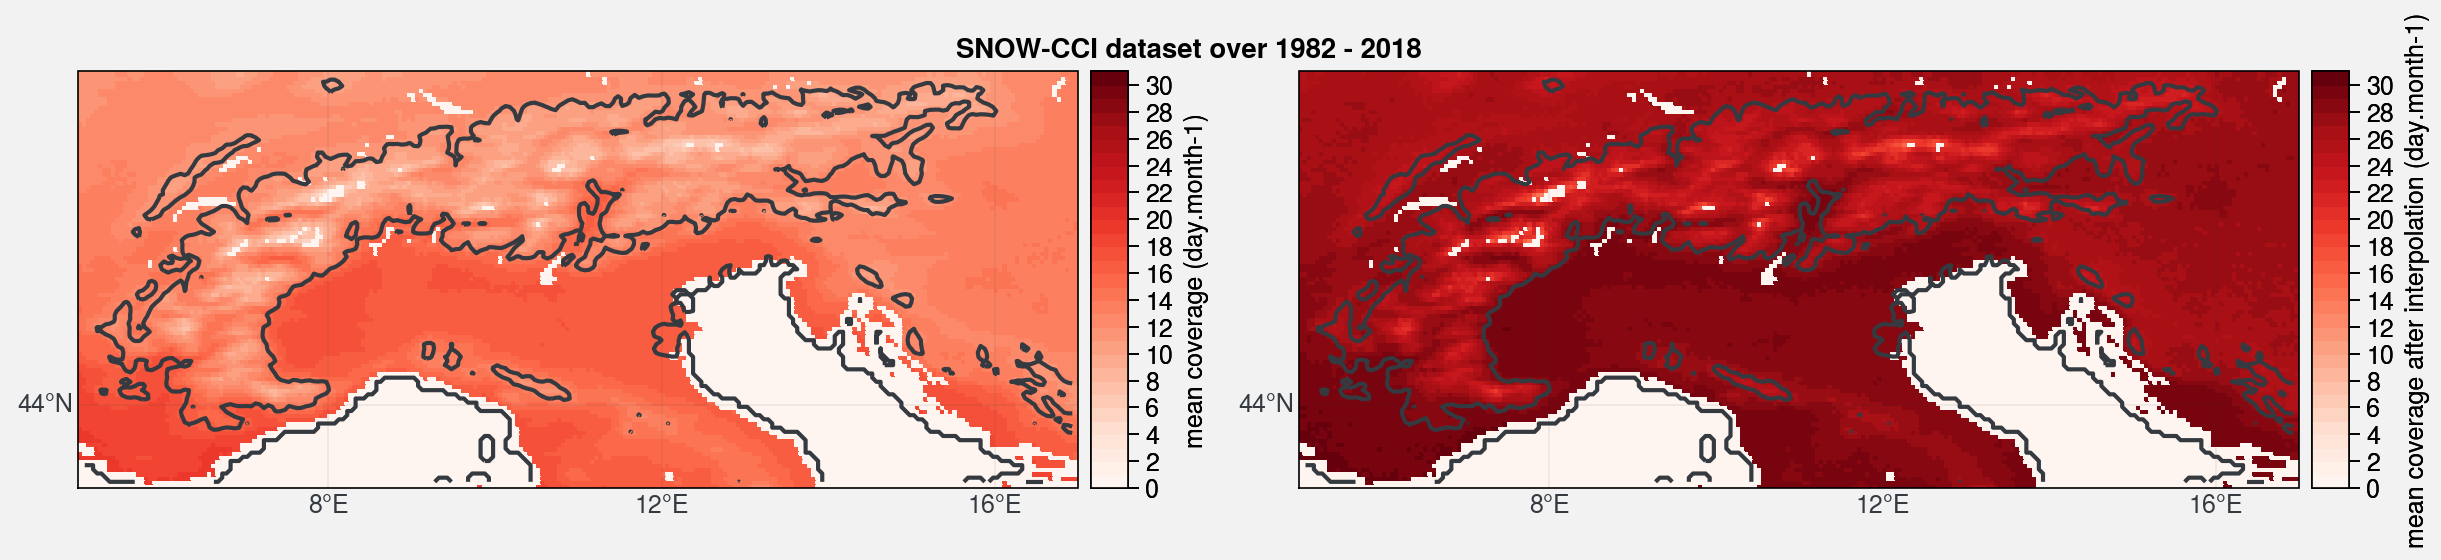

In [31]:
fig,axs = plot.subplots(proj='cyl',ncols=2, nrows=1, share=1, axwidth=5)

axs[0].pcolormesh(
        ds_alps.lon,ds_alps.lat,
        monthly_coverage_raw.mean(dim='month'),
        levels=levels_coverage,
        cmap=cmap_cov,
        colorbar='r', colorbar_kw={'label': 'mean coverage (day.month-1)'}
    )
axs[0].contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )

axs[1].pcolormesh(
        ds_alps.lon,ds_alps.lat,
        monthly_coverage_interp_raw.mean(dim='month'),
        levels=levels_coverage,
        cmap=cmap_cov,
        colorbar='r', colorbar_kw={'label': 'mean coverage after interpolation (day.month-1)'}
    )
axs[1].contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_coverage_'+str(first_year)+'-'+str(last_year)
fig.save(save_data+'/'+filename+'.png')

In [32]:
#ds_alps_mean=ds_alps.mean(dim='time',skipna=True) # Wrong calculation because of the daily values with nans
#ds_alps_mean.load()

In [33]:
#lon_loc=6.4; lat_loc=45.0
#ds_alps.coverage.sel(lon=lon_loc,lat=lat_loc)

In [34]:
# We extract only the first day (why an additional daily dimension have been added when opening the file?)
monthly_coverage_full=ds_alps.coverage.sel(time=ds_alps.time.dt.day == 1).load()
monthly_coverage_interp_full=ds_alps.coverage_interp.sel(time=ds_alps.time.dt.day == 1).load()

In [35]:
monthly_coverage_full.shape, ds_alps.coverage.shape

((441, 100, 240), (13422, 100, 240))

In [36]:
#Monthly trends initialisation
monthly_coverage=np.empty(shape=(monthly_coverage_full.shape[1],monthly_coverage_full.shape[2],months_per_year,int(ds_nbdays.nbdays.shape[2]/months_per_year)), dtype=float)
monthly_coverage_interp=np.empty(shape=(monthly_coverage_interp_full.shape[1],monthly_coverage_interp_full.shape[2],months_per_year,int(ds_nbdays.nbdays.shape[2]/months_per_year)), dtype=float)
for iyear, year in enumerate(range(first_year, last_year+1, 1)):
        for imonth, month in enumerate(range(1,months_per_year+1,1)):
            #print('year='+str(year)+', month='+str(month))
            if (year==1994 and (month==10 or month==11 or month==12)) or (year==1995 and month==1):
                print('no data for this period, we let the np.nan in the array')
            else:
                monthly_coverage[:,:,imonth,iyear]=monthly_coverage_full.sel(time=str(year)+'-'+str(month))
                monthly_coverage_interp[:,:,imonth,iyear]=monthly_coverage_interp_full.sel(time=str(year)+'-'+str(month))
monthly_mean_coverage=np.nanmean(monthly_coverage,axis=3)
monthly_coverage_nonan=np.copy(monthly_coverage)
monthly_mean_coverage_interp=np.nanmean(monthly_coverage_interp,axis=3)
monthly_coverage_interp_nonan=np.copy(monthly_coverage_interp)

no data for this period, we let the np.nan in the array
no data for this period, we let the np.nan in the array
no data for this period, we let the np.nan in the array
no data for this period, we let the np.nan in the array


In [37]:
monthly_coverage.shape, monthly_mean_coverage.shape, monthly_coverage_interp.shape, monthly_mean_coverage_interp.shape

((100, 240, 12, 37), (100, 240, 12), (100, 240, 12, 37), (100, 240, 12))

In [38]:
# Function to compute the trend over the dimension dim that is the last one of the input array
#def trend(array,dim):
#    slope=np.full(array.shape[0:dim],np.nan)
#    pvalue=np.full(array.shape[0:dim],np.nan)
#    array_nonan=np.copy(array)
#    array_mean=np.nanmean(axis=dim)
#    for xi in range(array.shape[0]):
#        print(str(xi+1)+'/'+str(array.shape[0]))
#        for yi in range(array.shape[1]):
#            for zi in range(array.shape[2]):
#                array_nonan[xi,yi,zi,:]=np.nan_to_num(array[xi,yi,zi,:],nan=array_mean[xi,yi,zi])
#                linregress_array=stats.linregress_array(range(array.shape[dim]),array_nonan[xi,yi,zi,:])
#                slope[xi][yi][zi]=linregress_array.slope
#                pvalue[xi][yi][zi]=linregress_array.pvalue
#    return slope, pvalue

In [39]:
#%%time
#slope_coverage_test,pvalue_coverage_test=trend(monthly_coverage,dim=3)

In [ ]:
# Computing trends
slope_coverage=np.full(monthly_coverage.shape[0:3],np.nan)
pvalue_coverage=np.full(monthly_coverage.shape[0:3],np.nan)
slope_coverage_interp=np.full(monthly_coverage_interp.shape[0:3],np.nan)
pvalue_coverage_interp=np.full(monthly_coverage_interp.shape[0:3],np.nan)
# Replacing the missing values by the mean before computing the trend
for lat in range(monthly_coverage.shape[0]):
    print(str(lat+1)+'/'+str(monthly_coverage.shape[0]))
    for lon in range(monthly_coverage.shape[1]):
        for imonth in range(months_per_year):
            monthly_coverage_nonan[lat,lon,imonth,:]=np.nan_to_num(monthly_coverage[lat,lon,imonth,:],nan=monthly_mean_coverage[lat,lon,imonth])
            linregress_coverage = stats.linregress(range(monthly_coverage.shape[3]), monthly_coverage_nonan[lat,lon,imonth,:])
            slope_coverage[lat][lon][imonth] = linregress_coverage.slope
            pvalue_coverage[lat][lon][imonth] = linregress_coverage.pvalue
            monthly_coverage_interp_nonan[lat,lon,imonth,:]=np.nan_to_num(monthly_coverage_interp[lat,lon,imonth,:],nan=monthly_mean_coverage_interp[lat,lon,imonth])
            linregress_coverage_interp = stats.linregress(range(monthly_coverage_interp.shape[3]), monthly_coverage_interp_nonan[lat,lon,imonth,:])
            slope_coverage_interp[lat][lon][imonth] = linregress_coverage_interp.slope
            pvalue_coverage_interp[lat][lon][imonth] = linregress_coverage_interp.pvalue

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100


In [ ]:
# Producing the map of the coverage mean
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        monthly_mean_coverage[:,:,i],#*mask_snow[:,:,i],
        #levels=levels,
        cmap=cmap_cov
    )
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    ax.format(title=months[i],titlesize='20px')#,labels=True)
    
f.colorbar(m, label= 'days.month-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly mean of snow cover data coverage, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_mean_coverage_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
factor_cov=10 # decadal trend
# Masking non-significative signals
signif_cov=np.where(pvalue_coverage<0.05,True,False)
levels_cov=plot.arange(-5,5,1)
levels_cov_percentage=plot.arange(-50,50,10)

In [ ]:
# Producing the map of the coverage trend
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        slope_coverage[:,:,i]*factor_cov,#*mask_snow[:,:,i],
        levels=levels_cov,
        cmap='bwr'
    )
    
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    
    ax.format(title=months[i],titlesize='20px')
    
    q = ax.contourf(
    ds_nbdays.lon,ds_nbdays.lat,
    signif_cov[:,:,i],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= 'days.decade-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly trend of data coverage, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_coverage_trends_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
# Producing the map of the coverage trend in percentage
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        slope_coverage[:,:,i]/monthly_mean_coverage[:,:,i]*100*factor_cov,#*mask_snow[:,:,i],
        levels=levels_cov_percentage,
        cmap='bwr'
    )
    
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    
    ax.format(title=months[i],titlesize='20px')
    
    q = ax.contourf(
    ds_nbdays.lon,ds_nbdays.lat,
    signif_cov[:,:,i],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= 'Percentage')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly trend of data coverage, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_coverage_percentage_trends_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
monthly_mean_coverage.shape, slope_coverage.shape

In [ ]:
yearly_mean_coverage=np.nansum(monthly_mean_coverage,axis=2)
yearly_slope_coverage=np.nansum(slope_coverage, axis=2)
yearly_mean_coverage_interp=np.nansum(monthly_mean_coverage_interp,axis=2)
yearly_slope_coverage_interp=np.nansum(slope_coverage_interp, axis=2)

In [ ]:
yearly_mean_coverage.shape, ds_nbdays.lon.shape, monthly_mean_coverage.shape, yearly_slope_coverage.shape

In [ ]:
ds_nbdays.lon.shape,ds_nbdays.lat.shape,yearly_slope_coverage.shape

In [ ]:
cmap_cov_mean='Reds'
cmap_cov_trend='bwr'
levels_cov=plot.arange(0,360,10)
levels_trends_cov=plot.arange(-30,30,5)
yearly_factor=10 # Signal per decade

In [ ]:
# Producing the map of the snow cover duration yearly mean and trends
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)

axs[0,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_coverage,
                    cmap=cmap_cov_mean,
                    levels=levels_cov,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[0,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[0,0].format(title='Mean data coverage before interpolation',titlesize='20px')

axs[0,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_coverage*yearly_factor,
                    cmap=cmap_cov_trend,
                    levels=levels_trends_cov,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                  )
axs[0,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[0,1].format(title='Trend of data coverage before interpolation',titlesize='20px')

axs[1,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_coverage_interp,
                    cmap=cmap_cov_mean,
                    levels=levels_cov,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[1,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[1,0].format(title='Mean data coverage after interpolation',titlesize='20px')

axs[1,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_coverage_interp*yearly_factor,
                    cmap=cmap_cov_trend,
                    levels=levels_trends_cov,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                  )
axs[1,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[1,1].format(title='Trend of data coverage after interpolation',titlesize='20px')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="SNOW-CCI coverage dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2],
)
filename = 'snow_cci_annual_mean_trend_coverage_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

***Compute monthly trends***

In [ ]:
# check one local trend
lon_loc=6.4; lat_loc=45.0
location_name='Col du Lautaret'
nbdays_loc=ds_nbdays.nbdays.sel(lon=lon_loc, lat=lat_loc, method="nearest")
nbdays2_loc=ds_nbdays.nbdays2.sel(lon=lon_loc, lat=lat_loc, method="nearest")

In [ ]:
# Monthly arrays and computing mean
monthly_nbdays_loc=np.empty(shape=(int(nbdays_loc.shape[0]/months_per_year),months_per_year), dtype=float)
monthly_nbdays2_loc=np.empty(shape=(int(nbdays_loc.shape[0]/months_per_year),months_per_year), dtype=float)
for imonth in range(0,months_per_year,1):
    monthly_nbdays_loc[:,imonth]=nbdays_loc.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
    monthly_nbdays2_loc[:,imonth]=nbdays2_loc.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
monthly_mean_nbdays_loc=np.nanmean(monthly_nbdays_loc,axis=0)
monthly_mean_nbdays2_loc=np.nanmean(monthly_nbdays_loc,axis=0)
monthly_nbdays_loc_nonan=np.copy(monthly_nbdays_loc)
monthly_nbdays2_loc_nonan=np.copy(monthly_nbdays2_loc)

In [ ]:
# Computing trends
slope_nbdays_loc=np.full(months_per_year,np.nan)
pvalue_nbdays_loc=np.full(months_per_year,np.nan)
intercept_nbdays_loc=np.full(months_per_year,np.nan)
# We replace the missing values with the mean before computing the trend -> Should not affect the trend. linregress not usable with nans...
for imonth in range(months_per_year):
    monthly_nbdays_loc_nonan[:,imonth]=np.nan_to_num(monthly_nbdays_loc[:,imonth],nan=monthly_mean_nbdays_loc[imonth])
    linregress_nbdays_loc = stats.linregress(range(monthly_nbdays_loc.shape[0]), monthly_nbdays_loc_nonan[:,imonth])
    slope_nbdays_loc[imonth] = linregress_nbdays_loc.slope
    intercept_nbdays_loc[imonth] = linregress_nbdays_loc.intercept
    pvalue_nbdays_loc[imonth] = linregress_nbdays_loc.pvalue

In [ ]:
plt.plot(monthly_nbdays_loc[:,11])

In [ ]:
plt.plot(monthly_nbdays_loc_nonan[:,11])

In [ ]:
# Trends for nbdays2, with different threshold for extrapolating missing values.
slope_nbdays2_loc=np.full(months_per_year,np.nan)
pvalue_nbdays2_loc=np.full(months_per_year,np.nan)
intercept_nbdays2_loc=np.full(months_per_year,np.nan)
for imonth in range(months_per_year):
    monthly_nbdays2_loc_nonan[:,imonth]=np.nan_to_num(monthly_nbdays2_loc[:,imonth],nan=monthly_mean_nbdays2_loc[imonth])
    linregress_nbdays2_loc = stats.linregress(range(monthly_nbdays2_loc.shape[0]), monthly_nbdays2_loc_nonan[0:,imonth])
    slope_nbdays2_loc[imonth] = linregress_nbdays2_loc.slope
    intercept_nbdays2_loc[imonth] = linregress_nbdays2_loc.intercept
    pvalue_nbdays2_loc[imonth] = linregress_nbdays2_loc.pvalue

In [ ]:
# Plot local timeseries and trends for all the months
fig, axs = plot.subplots(nrows=4, ncols=3,sharey=True)
year_time = pd.date_range(start=str(first_year),end=str(last_year+1),freq='Y')
index=np.arange(0,year_time.shape[0])
for i, ax in enumerate(axs):
    m = ax.axhline(monthly_mean_nbdays_loc[i], color='royalblue', linewidth=1)  # monthly mean
    m = ax.scatter(year_time,monthly_nbdays_loc[:,i])
    if pvalue_nbdays_loc[i]<0.05:
        signif='solid'
        color='red'
    else:
        signif='dashed'
        color='blue'
    if pvalue_nbdays2_loc[i]<0.05:
        signif2='solid'
    else:
        signif2='dashed'
    m = ax.plot(year_time,intercept_nbdays_loc[i]+slope_nbdays_loc[i]*index,linestyle=signif)
    ax.format(title=f"{months[i]} trend={slope_nbdays_loc[i]*10:.2f} days.decade-1; pvalue={pvalue_nbdays_loc[i]:.2g}",titlesize=9,titlecolor=color)
    # Trends computed xith a different threshold for missing values.
    m = ax.plot(year_time,intercept_nbdays2_loc[i]+slope_nbdays2_loc[i]*index,linestyle=signif2, color='orange')
axs.format(suptitle=location_name, ylabel='Snow cover duration (days.month-1)')
filename = 'snow_cci_local_'+str(first_year)+'-'+str(last_year)
fig.save(save_data+'/'+filename+'.png')

***Spatial trends***

In [ ]:
# Monthly arrays and computing mean
monthly_nbdays=np.empty(shape=(ds_nbdays.nbdays.shape[0],ds_nbdays.nbdays.shape[1],months_per_year,int(ds_nbdays.nbdays.shape[2]/months_per_year)), dtype=float)
monthly_nbdays2=np.empty(shape=(ds_nbdays.nbdays.shape[0],ds_nbdays.nbdays.shape[1],months_per_year,int(ds_nbdays.nbdays.shape[2]/months_per_year)), dtype=float)
for imonth in range(0,months_per_year,1):
    monthly_nbdays[:,:,imonth,:]=ds_nbdays.nbdays.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
    monthly_nbdays2[:,:,imonth,:]=ds_nbdays.nbdays2.sel(time=ds_nbdays.time.dt.month.isin([imonth+1]))
monthly_mean_nbdays=np.nanmean(monthly_nbdays,axis=3)
monthly_mean_nbdays2=np.nanmean(monthly_nbdays2,axis=3)
monthly_nbdays_nonan=np.copy(monthly_nbdays)
monthly_nbdays2_nonan=np.copy(monthly_nbdays2)

In [ ]:
# Computing trends
slope_nbdays=np.full(monthly_nbdays.shape[0:3],np.nan)
pvalue_nbdays=np.full(monthly_nbdays.shape[0:3],np.nan)
# Replacing the missing values by the mean before computing the trend
for lat in range(monthly_nbdays.shape[0]):
    print(str(lat+1)+'/'+str(monthly_nbdays.shape[0]))
    for lon in range(monthly_nbdays.shape[1]):
        for imonth in range(months_per_year):
            #monthly_nbdays_nonan[lat,lon,imonth,:][np.isnan(monthly_nbdays[lat,lon,imonth,:])]=monthly_mean_nbdays[lat,lon,imonth]
            monthly_nbdays_nonan[lat,lon,imonth,:]=np.nan_to_num(monthly_nbdays[lat,lon,imonth,:],nan=monthly_mean_nbdays[lat,lon,imonth])
            linregress_nbdays = stats.linregress(range(monthly_nbdays.shape[3]), monthly_nbdays_nonan[lat,lon,imonth,:])
            slope_nbdays[lat][lon][imonth] = linregress_nbdays.slope
            pvalue_nbdays[lat][lon][imonth] = linregress_nbdays.pvalue

In [ ]:
# Computing trends for nbdays2
slope_nbdays2=np.full(monthly_nbdays2.shape[0:3],np.nan)
pvalue_nbdays2=np.full(monthly_nbdays2.shape[0:3],np.nan)
# Replacing the missing values by the mean before computing the trend
for lat in range(monthly_nbdays2.shape[0]):
    print(str(lat+1)+'/'+str(monthly_nbdays2.shape[0]))
    for lon in range(monthly_nbdays2.shape[1]):
        for imonth in range(months_per_year):
            monthly_nbdays2_nonan[lat,lon,imonth,:]=np.nan_to_num(monthly_nbdays2[lat,lon,imonth,:],nan=monthly_mean_nbdays2[lat,lon,imonth])
            linregress_nbdays2 = stats.linregress(range(monthly_nbdays2.shape[3]), monthly_nbdays2_nonan[lat,lon,imonth,:])
            slope_nbdays2[lat][lon][imonth] = linregress_nbdays2.slope
            pvalue_nbdays2[lat][lon][imonth] = linregress_nbdays2.pvalue

In [ ]:
# Masking values where there is no snow
mask_snow=np.where(monthly_mean_nbdays<3,np.nan,True)

In [ ]:
cmap_mean='GnBu'

In [ ]:
# Producing the map of the snow cover duration mean
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        monthly_mean_nbdays[:,:,i],#*mask_snow[:,:,i],
        #levels=levels,
        cmap=cmap_mean
    )
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    ax.format(title=months[i],titlesize='20px')#,labels=True)
    
f.colorbar(m, label= 'days.month-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly mean of snow cover duration, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_mean_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
# Masking non-significative signals
signif=np.where(pvalue_nbdays<0.05,True,False)
signif2=np.where(pvalue_nbdays2<0.05,True,False)

In [ ]:
# Levels for the plot
#levels=plot.arange(-0.3,0.3,0.05)
factor=10 # degree per decade

In [ ]:
# Producing the map of the trends
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        slope_nbdays[:,:,i]*factor*mask_snow[:,:,i],
        #levels=levels,
        cmap='BrBg'
    )
    
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    
    ax.format(title=months[i],titlesize='20px')
    
    q = ax.contourf(
    ds_nbdays.lon,ds_nbdays.lat,
    signif[:,:,i],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= 'days.decade-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly trend of snow cover duration, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)
filename = 'snow_cci_trends_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
# Producing the map of the trends for nbdays2
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=4, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds_nbdays.lon,ds_nbdays.lat,
        slope_nbdays2[:,:,i]*factor*mask_snow[:,:,i],
        #levels=levels,
        cmap='BrBg'
    )
    
    p = ax.contour(
        dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8',
    )
    
    ax.format(title=months[i],titlesize='20px')
    
    q = ax.contourf(
    ds_nbdays.lon,ds_nbdays.lat,
    signif2[:,:,i],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= 'days.decade-1')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="Monthly trend of snow cover duration, nbdays2, SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2]
)


***Yearly mean and trend***

In [ ]:
yearly_mean_nbdays=np.nansum(monthly_mean_nbdays,axis=2)
yearly_mean_nbdays2=np.nansum(monthly_mean_nbdays2,axis=2)
yearly_slope_nbdays=np.nansum(slope_nbdays, axis=2)
yearly_slope_nbdays2=np.nansum(slope_nbdays2, axis=2)

In [ ]:
yearly_mean_nbdays.shape

In [ ]:
cmap_mean='GnBu'
cmap_trend='BrBg'
levels=plot.arange(0,250,10)
diff_levels=plot.arange(-25,25,1)
levels_trends=plot.arange(-20,20,5)
diff_level_trends=plot.arange(-5,5,1)
yearly_factor=10 # Signal per decade

In [ ]:
# Producing the map of the snow cover duration yearly mean and trends
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=2, share=1, axwidth=5)

axs[0,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_nbdays,
                    cmap=cmap_mean,
                    levels=levels,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[0,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[0,0].format(title='Mean snow cover duration, min_coverage='+str(min_available_values)+' days',titlesize='20px')

axs[0,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_nbdays2,
                    cmap=cmap_mean,
                    levels=levels,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                  )
axs[0,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[0,1].format(title='Mean snow cover duration, min_coverage='+str(min_available_values2)+' days',titlesize='20px')

axs[0,2].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_nbdays2-yearly_mean_nbdays,
                    cmap=cmap_trend,
                    levels=diff_levels,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                  )
axs[0,2].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[0,2].format(title='Mean difference min_coverage='+str(min_available_values2)+' minus min_coverage='+str(min_available_values)+' days',titlesize='20px')


axs[1,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_nbdays*yearly_factor,
                    cmap=cmap_trend,
                    levels=levels_trends,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                   )
axs[1,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[1,0].format(title='Snow cover duration trend, min_coverage='+str(min_available_values)+' days',titlesize='20px')

axs[1,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_nbdays2*yearly_factor,
                    cmap=cmap_trend,
                    levels=levels_trends,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                   )
axs[1,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[1,1].format(title='Snow cover duration trend, min_coverage='+str(min_available_values2)+' days',titlesize='20px')

axs[1,2].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,(yearly_slope_nbdays2-yearly_slope_nbdays)*yearly_factor,
                    cmap=cmap_trend,
                    levels=diff_level_trends,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                   )
axs[1,2].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[1,2].format(title='Trend difference min_coverage='+str(min_available_values2)+' minus min_coverage='+str(min_available_values)+' days',titlesize='20px')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="SNOW-CCI dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=False, latlim=[lat1,lat2],lonlim=[lon1,lon2],
)
filename = 'snow_cci_annual_mean_trend_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

***Trends as a function of elevation***

In [ ]:
# Levels of temperature for the plot
#levels=np.arange(-0.5,0.5,0.05)
factor_trend=10 # degree per decade
#bins=100
levels=np.logspace(0,1,25)

In [ ]:
slope_nbdays.shape

In [ ]:
# We keep only the elevation area > limit m.asl
limit=200
topo_high=dsi_topo.elevation.where(dsi_topo.elevation > limit)
trends_high=np.zeros(slope_nbdays.shape)
trends_high_signif=np.zeros(slope_nbdays.shape)
trends_high_no_signif=np.zeros(slope_nbdays.shape)
for i in np.arange(months_per_year):
    trends_high[:,:,i]=np.where(dsi_topo.elevation > limit,slope_nbdays[:,:,i],np.nan)
    trends_high_signif[:,:,i]=np.where(pvalue_nbdays[:,:,i] < 0.05,trends_high[:,:,i],np.nan)
    trends_high_no_signif[:,:,i]=np.where(pvalue_nbdays[:,:,i] >= 0.05,trends_high[:,:,i],np.nan)

In [ ]:
# nbdays2, we keep only the elevation area > limit m.asl
limit=200
topo_high=dsi_topo.elevation.where(dsi_topo.elevation > limit)
trends_high2=np.zeros(slope_nbdays2.shape)
trends_high2_signif=np.zeros(slope_nbdays2.shape)
trends_high2_no_signif=np.zeros(slope_nbdays2.shape)
for i in np.arange(months_per_year):
    trends_high2[:,:,i]=np.where(dsi_topo.elevation > limit,slope_nbdays2[:,:,i],np.nan)
    trends_high2_signif[:,:,i]=np.where(pvalue_nbdays2[:,:,i] < 0.05,trends_high2[:,:,i],np.nan)
    trends_high2_no_signif[:,:,i]=np.where(pvalue_nbdays2[:,:,i] >= 0.05,trends_high2[:,:,i],np.nan)

In [ ]:
#Plotting trends as a function of elevation
f, axs = plot.subplots(ncols=3, nrows=4,share=1)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.scatter(trends_high_signif[:,:,i].flatten()*factor_trend,topo_high.values.flatten(),alpha=0.1,color='red')
    #m = ax.scatter(trends_high_no_signif[:,:,i].flatten()*factor_trend,topo_high.values.flatten(),alpha=0.1,color='blue')
    ax.format(title=months[i],titlesize='20px')#,ylim=(-0.05,0.25))

axs.format(
    suptitle='Snow cover duration trend as a function of the topography',
    xlabel='Elevation (m. asl)',
    ylabel='trends (days.decade-1)',
    titlesize='20px'
)
filename = 'snow_cci_trend_versus_elevation_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
#Plotting trends as a function of elevationwith nbdays2
f, axs = plot.subplots(ncols=3, nrows=4,share=1)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.scatter(trends_high2_signif[:,:,i].flatten()*factor_trend,topo_high.values.flatten(),alpha=0.1,color='red')
    #m = ax.scatter(trends_high2_no_signif[:,:,i].flatten()*factor_trend,topo_high.values.flatten(),alpha=0.1,color='blue')
    ax.format(title=months[i],titlesize='20px')#,ylim=(-0.05,0.25))

axs.format(
    suptitle='Snow cover duration trend as a function of the topography, nbdays2',
    xlabel='Elevation (m. asl)',
    ylabel='trends (days.decade-1)',
    titlesize='20px'
)
filename = 'snow_cci_nbdays20_trend_versus_elevation_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')

In [ ]:
levels_snow=plot.arange(0,350,25)
levels_trends=plot.arange(-30,30,5)

In [ ]:
# Plot for the SNOW-CCI report
# Producing the map of the snow cover duration yearly mean and trends
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=3, share=1, axwidth=5)

axs[0,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_nbdays,
                    cmap=cmap_mean,
                    levels=levels_snow,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[0,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[0,0].format(title='Mean snow cover duration',titlesize='20px')

axs[0,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_nbdays*yearly_factor,
                    cmap=cmap_trend,
                    levels=levels_trends,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                   )
axs[0,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[0,1].format(title='Snow cover duration trend',titlesize='20px')


axs[1,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_coverage,
                    cmap=cmap_cov_mean,
                    levels=levels_snow,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[1,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[1,0].format(title='Mean data coverage before interpolation',titlesize='20px')

axs[1,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_coverage*yearly_factor,
                    cmap=cmap_cov_trend,
                    levels=levels_trends_cov,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                  )
axs[1,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[1,1].format(title='Trend of data coverage before interpolation',titlesize='20px')

axs[2,0].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_mean_coverage_interp,
                    cmap=cmap_cov_mean,
                    levels=levels_snow,
                    colorbar='r', colorbar_kw={'label': 'days.year-1'},
                   )

axs[2,0].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')

axs[2,0].format(title='Mean data coverage after interpolation',titlesize='20px')

axs[2,1].pcolormesh(ds_nbdays.lon,ds_nbdays.lat,yearly_slope_coverage_interp*yearly_factor,
                    cmap=cmap_cov_trend,
                    levels=levels_trends_cov,
                    colorbar='r', colorbar_kw={'label': 'days.decade-1'},
                  )
axs[2,1].contour(dsi_topo.lon,dsi_topo.lat,dsi_topo.elevation,
        levels=levels_elev,color='gray8')
axs[2,1].format(title='Trend of data coverage after interpolation',titlesize='20px')

axs.format(
    gridlinewidth=0.1, gridcolor='gray8', gridalpha=0.5, labels=True, 
    coast=False, ocean=False, oceancolor='gray3', borders=False,
    suptitle="SNOW-CCI coverage dataset over "+str(first_year)+" - "+str(last_year),
    lonlines=4, latlines=4, abc=True, abcstyle='a', latlim=[lat1,lat2],lonlim=[lon1,lon2],
)
filename = 'snow_cci_annual_mean_trend_snow+coverage_Alps_'+str(first_year)+'-'+str(last_year)
f.save(save_data+'/'+filename+'.png')